## The Affine Sampler
This MCMC sampler is an adaption of the emcee sampler implemented in tensorflow which utilizes GPU computing. The goal is to compare Affine to Emcee.

In [194]:
from affine import *
import emcee
import numpy as np
import tensorflow as tf
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool

In [195]:
_d = 5

cov = np.diag(np.ones(_d))
mean = np.zeros(_d)

inv_cov = np.linalg.inv(cov)

def lkl(theta):
    diff = theta-mean
    g_lkl =  tf.matmul(diff, inv_cov)
    g_lkl = tf.matmul(g_lkl,tf.transpose(diff))
    g_lkl = tf.linalg.diag_part(g_lkl)
    return g_lkl

def pr(theta):
    #hard prior:
    l = len(theta)
    lims = np.full((l,_d),3)
    if( np.any(lims-theta)<0 or np.any(theta+lims)<0):
        return(np.full(l,-1*np.inf))
    return np.zeros(l)

def log_prob(theta):
    return -0.5*(lkl(theta)+pr(theta))

In [203]:
n_walkers = 60

# initialize walkers and current state
walkers1 = tf.random.normal([n_walkers, _d], 0., .1)
walkers2 = tf.random.normal([n_walkers, _d], 0., .1)
current_state = [walkers1, walkers2]
n_steps = 50000

In [204]:
# run the sampler
chain = affine_sample(log_prob, n_steps, current_state, args=[])

100%|████████████████████████████████████████████| 49999/49999 [05:10<00:00, 160.85it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

time/bfc_allocator.cc:1066] InUse at 23089e7300 of size 2560 next 41792
2022-06-14 15:42:48.257118: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 23089e7d00 of size 2560 next 41798
2022-06-14 15:42:48.257121: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 23089e8700 of size 2560 next 41794
2022-06-14 15:42:48.257123: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 23089e9100 of size 2560 next 41800
2022-06-14 15:42:48.257125: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 23089e9b00 of size 2560 next 41801

ResourceExhaustedError: OOM when allocating tensor with shape[50000,120,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [205]:
# plot using getdist
burnin = 100
samples = chain[burnin:].numpy()
print(samples.shape)
s = np.reshape(samples,((n_steps-burnin)*2*n_walkers,_d))

names = [r"x_1", 
         r"x_2", 
         r"x_3", 
         r"x_4",
         r"x_5"]#, 
         #r"x_6", 
         #r"x_7",
         #r"x_8",
         #r"x_9",
         #r"x_10"]
labels = names
mcsamples = MCSamples(samples=s,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.triangle_plot([mcsamples], filled=True, legend_labels=['test'])
plt.show()

(200, 1000, 5)


ValueError: cannot reshape array of size 1000000 into shape (5988000,5)

In [180]:
# now with emcee.

def lkl(theta):
    diff = theta-mean
    g_lkl = np.matmul(diff, inv_cov)
    g_lkl = np.matmul(g_lkl,np.transpose(diff))
    #g_lkl = np.linalg.diag_part(g_lkl)
    return g_lkl

def pr(theta):
    #hard prior:
    l = len(theta)
    lims = np.full((l,_d),3)
    if( np.any(lims-theta)<0 or np.any(theta+lims)<0):
        return(np.full(l,-1*np.inf))
    return np.zeros(l)

def log_prob(theta):
    return -0.5*(lkl(theta)+pr(theta))

In [168]:
pos0 = np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(n_walkers, _d, log_prob, pool=pool)
    emu_sampler.run_mcmc(pos0, n_steps, progress=True)

100%|██████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.60it/s]


Removed no burn in


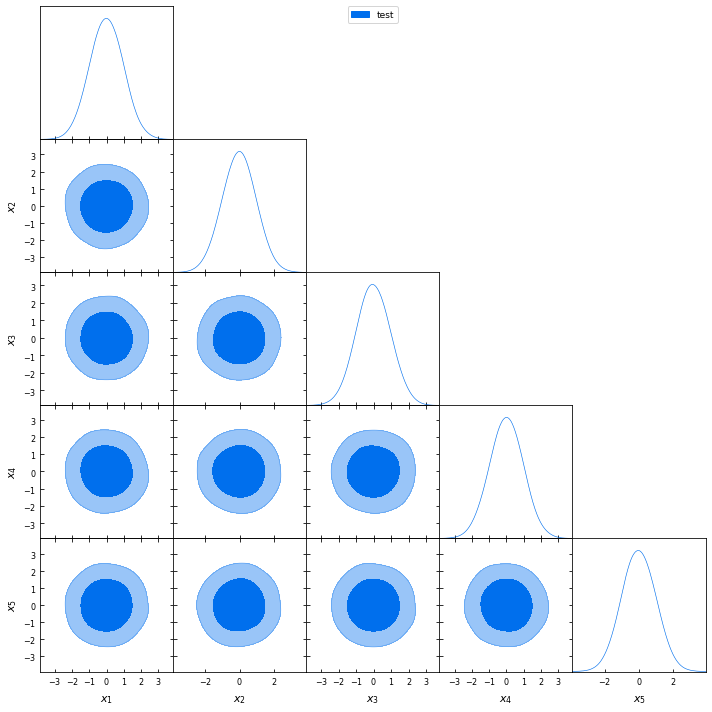

In [169]:
s = emu_sampler.chain[:,burnin:].reshape((-1,NDIM_SAMPLING))
mcsamples = MCSamples(samples=s,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.triangle_plot([mcsamples], filled=True, legend_labels=['test'])
plt.show()